## CASE STUDY 002

Aplicando SOM para análise do acumulado de flashes horário em cada estado brasileiro por estação com os dados nao normalizados

In [2]:
import sys; sys.path.insert(0, "/home/adriano/sthunder")
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sthunder import constants as const
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import shapely.geometry as sgeom
from descartes import PolygonPatch

import xarray as xr
from minisom import MiniSom

In [3]:
df = pd.read_csv("/glm/city_state.csv")[['total', 'datetime']]
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,total,datetime
0,0,2020-01-01 00:00:00
1,0,2020-01-01 01:00:00
2,0,2020-01-01 02:00:00
3,0,2020-01-01 03:00:00
4,0,2020-01-01 04:00:00


In [4]:
df['stations'] = -1
df.set_index('datetime', drop=True, inplace=True)
df.loc["2020-03-21" : "2020-06-20", ['stations']] = 0 # "autumn"
df.loc["2020-06-21" : "2020-09-22", ['stations']] = 1 # "winter"
df.loc["2020-09-23" : "2020-12-21", ['stations']] = 2 # "spring"
df.loc["2020-12-22" : "2021-01-01", ['stations']] = 3 # "summner"
df.loc["2020-01-01" : "2020-03-20", ['stations']] = 3 # "summner"
df.head()

,total,stations
datetime,,
2020-01-01 00:00:00,0,3
2020-01-01 01:00:00,0,3
2020-01-01 02:00:00,0,3
2020-01-01 03:00:00,0,3
2020-01-01 04:00:00,0,3


In [5]:
# 70, 75, 80, 85, 90, 91, 92, 93, 94, 95, 97, 99
def p70(x): return np.percentile(x, 70)
def p75(x): return np.percentile(x, 75)
def p80(x): return np.percentile(x, 80)
def p85(x): return np.percentile(x, 85)
def p90(x): return np.percentile(x, 90)
def p91(x): return np.percentile(x, 91)
def p92(x): return np.percentile(x, 92)
def p93(x): return np.percentile(x, 93)
def p94(x): return np.percentile(x, 94)
def p95(x): return np.percentile(x, 95)
def p97(x): return np.percentile(x, 97)
def p99(x): return np.percentile(x, 99)

flashes_df = df.groupby(
    ['stations', pd.Grouper(freq='D')]
).aggregate({
    'total': ['max', 'sum', 'mean', 'std',# p70, p75, p80, 
              p85, p90, p91, p92, p93, p94, p95, 
              p97, p99]
}).reset_index()

flashes_df.head()

stations   datetime total                                                   \
                        max     sum      mean        std  p85  p90  p91  p92   
0        0 2020-03-21  1596  172248  2.544133  27.350488  0.0  0.0  0.0  0.0   
1        0 2020-03-22  1690  227226  3.356168  34.579813  0.0  0.0  0.0  0.0   
2        0 2020-03-23  2129  241168  3.562094  31.283398  0.0  0.0  0.0  1.0   
3        0 2020-03-24  1154  244682  3.613996  28.092836  0.0  0.0  1.0  2.0   
4        0 2020-03-25  1081  148564  2.194316  21.421056  0.0  0.0  0.0  0.0   

                              
   p93  p94  p95   p97   p99  
0  0.0  1.0  2.0  10.0  56.0  
1  0.0  1.0  3.0  13.0  75.0  
2  2.0  3.0  6.0  21.0  95.0  
3  3.0  5.0  8.0  24.0  93.0  
4  0.0  1.0  3.0  10.0  54.0

In [6]:
flashes_df

stations   datetime total                                              \
                          max     sum      mean        std  p85  p90  p91   
0          0 2020-03-21  1596  172248  2.544133  27.350488  0.0  0.0  0.0   
1          0 2020-03-22  1690  227226  3.356168  34.579813  0.0  0.0  0.0   
2          0 2020-03-23  2129  241168  3.562094  31.283398  0.0  0.0  0.0   
3          0 2020-03-24  1154  244682  3.613996  28.092836  0.0  0.0  1.0   
4          0 2020-03-25  1081  148564  2.194316  21.421056  0.0  0.0  0.0   
..       ...        ...   ...     ...       ...        ...  ...  ...  ...   
361        3 2020-12-27  1073  299360  4.421600  34.471371  0.0  0.0  0.0   
362        3 2020-12-28  2160  366008  5.406003  43.510445  0.0  0.0  1.0   
363        3 2020-12-29  1761  337123  4.979366  41.093910  0.0  0.0  0.0   
364        3 2020-12-30  2051  359568  5.310883  49.676470  0.0  0.0  0.0   
365        3 2020-12-31  2093  510010  7.532937  57.547282  0.0  0.0  1.0   

                                        
     p92  p93  p94   p95   p97     p99  
0    0.0  0.0  1.0   2.0  10.0   56.00  
1    0.0  0.0  1.0   3.0  13.0   75.00  
2    1.0  2.0  3.0   6.0  21.0   95.00  
3    2.0  3.0  5.0   8.0  24.0   93.00  
4    0.0  0.0  1.0   3.0  10.0   54.00  
..   ...  ...  ...   ...   ...     ...  
361  1.0  2.0  4.0   7.0  27.0  122.00  
362  1.0  3.0  5.0  10.0  34.0  147.00  
363  1.0  2.0  3.0   6.0  24.0  140.00  
364  0.0  0.0  1.0   4.0  22.0  137.97  
365  2.0  5.0  9.0  16.0  50.0  200.97  

[366 rows x 15 columns]

In [7]:
np.sqrt(5*np.sqrt(366))

9.780369744981268

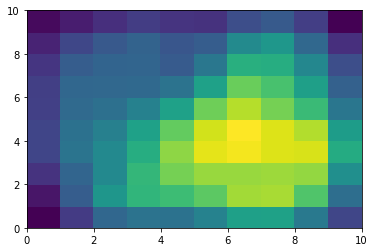

In [8]:
data = flashes_df.iloc[:, 2:].values
nrow, ncol = 10, 10

SOM = MiniSom(x=nrow, y=ncol, input_len=data.shape[1], sigma=4, learning_rate=0.5, 
              neighborhood_function='gaussian',
#               neighborhood_function='bubble',
             topology='rectangular', activation_distance='euclidean', random_seed=42)
SOM.random_weights_init(data=data)
SOM.train_random(data=data, num_iteration=2000)

plt.pcolor(SOM.distance_map().T)

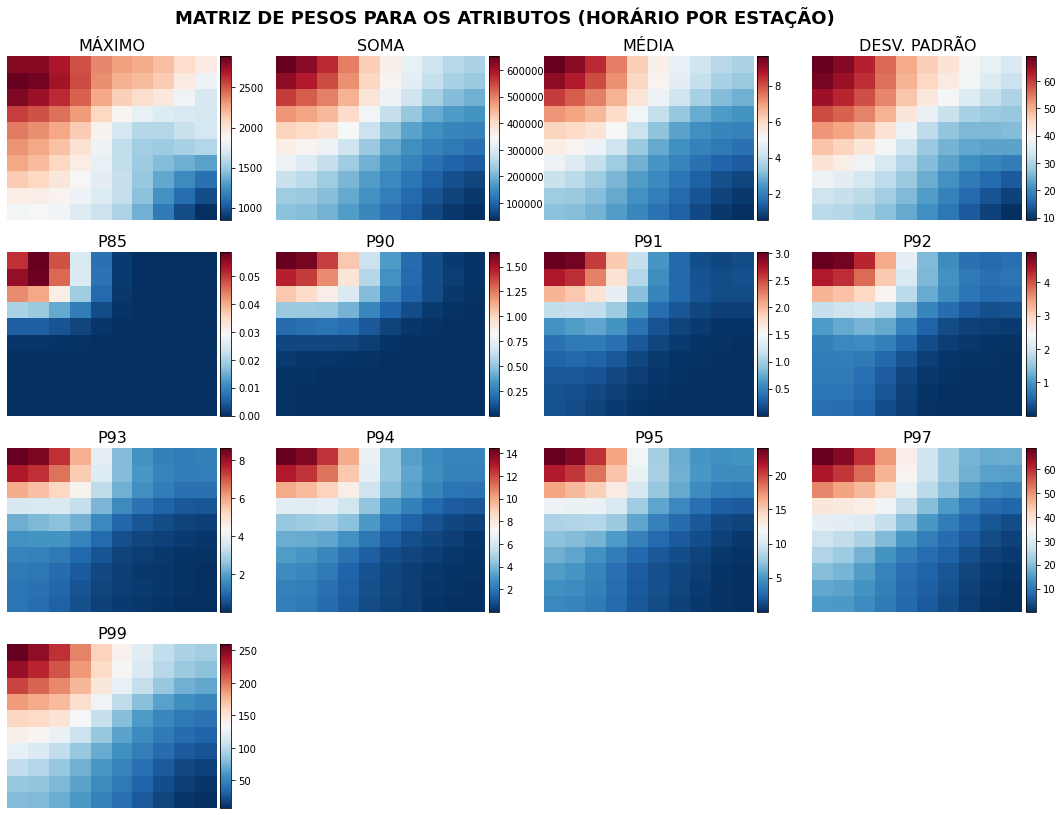

In [9]:
dpi = 100
width = np.round(1366 * 135 / 100)
height = 768*1.8
    
fig, ax = plt.subplots(4, 4, figsize=(width/dpi, height/dpi), facecolor = 'white')
fig.suptitle(f"MATRIZ DE PESOS PARA OS ATRIBUTOS (HORÁRIO POR ESTAÇÃO)", 
             fontsize=18, fontweight='bold', y=0.93)

columns = ('MÁXIMO', 'SOMA', 'MÉDIA', 'DESV. PADRÃO',# 'P70', 'P75', 'P80', 
           'P85', 'P90', 'P91', 'P92', 'P93', 'P94', 'P95', 'P97',
          'P99')
for i in range(16):
    row = i//4
    col = i%4
    if row == 3 and col > 0:
        ax[row][col].axis('off')
    else:
        divider = make_axes_locatable(ax[row][col])
        cax = divider.append_axes('right', size='5%', pad=0.05)

        ax[row][col].set_title(columns[i], fontdict={'size': 16})
        img = ax[row][col].pcolor(SOM._weights[:, :, i], cmap='RdBu_r')
        fig.colorbar(img, cax=cax, orientation='vertical')
        ax[row][col].axis('off')
    
plt.savefig(f"../weights_uf_hourly_nn_stations.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [10]:
smaps = [
    np.full((*SOM._weights.shape[:-1],), 0), 
    np.full((*SOM._weights.shape[:-1],), 0),
    np.full((*SOM._weights.shape[:-1],), 0),
    np.full((*SOM._weights.shape[:-1],), 0)
]


colors = ['#592a06', '#00f6ff', '#ffe20c', '#f2592b']

for i, row in flashes_df.iterrows():
#     print(row['stations'][0])
    x, y = SOM.winner(row[2:].values.astype(np.float32))
    
    smaps[row['stations'][0]][x][y] += 1
    
smaps = np.array(smaps)

In [11]:
color_map = np.full((*SOM._weights.shape[:-1],), 0)
alpha_map = np.full((*SOM._weights.shape[:-1],), 0.)


for i in range(alpha_map.shape[0]):
    for j in range(alpha_map.shape[1]):
        maxv = smaps[:, i, j].max()
        sumv = smaps[:, i, j].sum()
        idxv = np.argmax(smaps[:, i, j])
        
        color_map[i][j] = idxv
        alpha_map[i][j] = maxv/sumv
alpha_map[np.isnan(alpha_map)] = 0
# for i in range(4):
#     x, y = np.where(color_map == colors[i])
#     if len(x) > 0:
#         alpha_map[x, y] = alpha_map[x, y]/alpha_map[x, y].max()

/home/adriano/sthunder/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


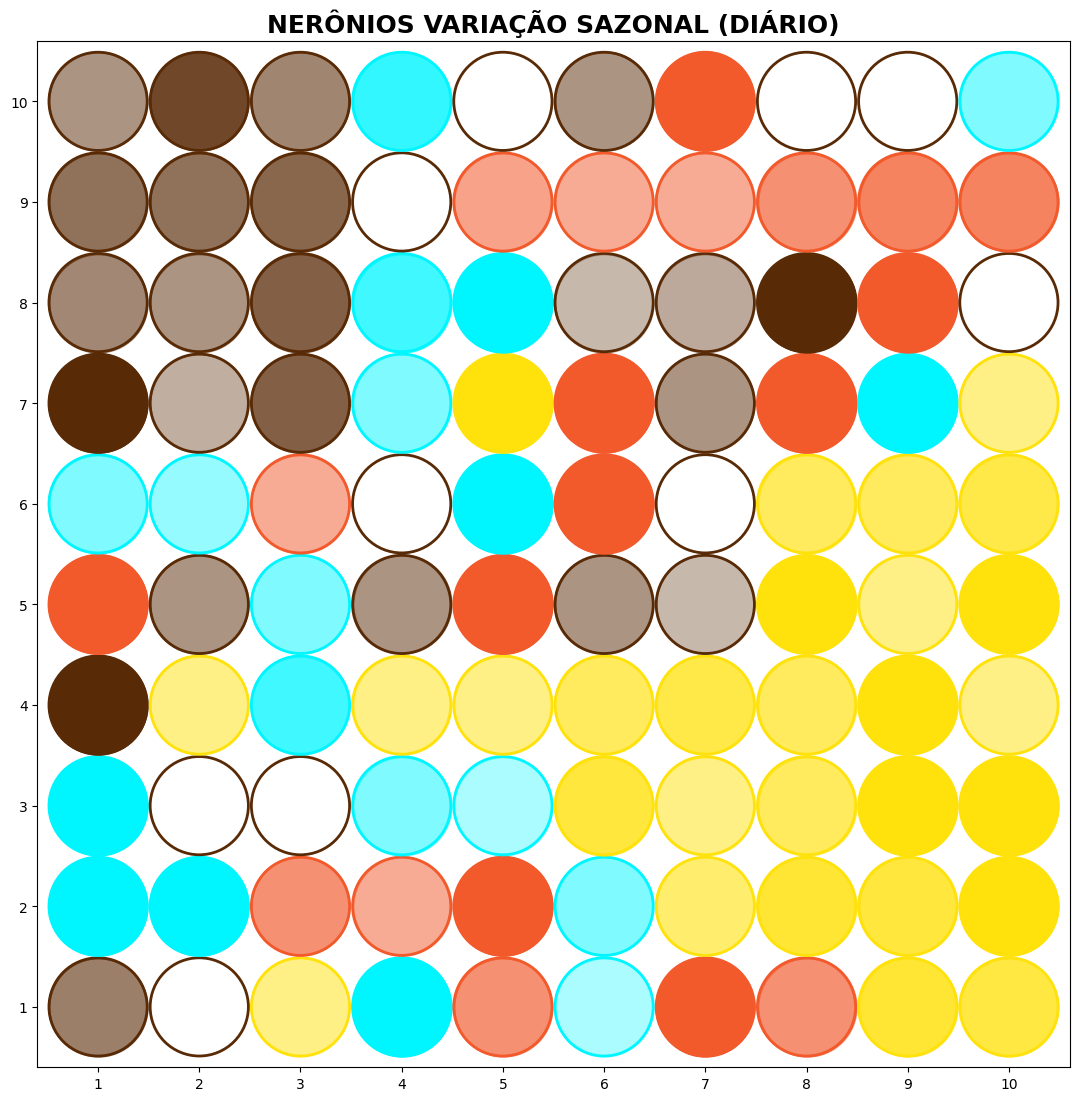

In [12]:
dpi = 100
width = np.round(1366 * 97.5 / 100)
height = 768*1.77
facecolor = 'white'

fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor=facecolor)

ax.set_title("NERÔNIOS VARIAÇÃO SAZONAL (DIÁRIO)", fontdict={'size': 18, 'weight': 'bold'})

for i in range(color_map.shape[0]):
    for j in range(color_map.shape[1]):
        ax.scatter([i+.5], [j+.5], color=colors[color_map[i][j]], marker='o', s=5000, alpha=alpha_map[i][j],
            lw=1.5, ec=colors[color_map[i][j]], zorder=1)
        ax.scatter([i+.5], [j+.5], color='none', marker='o', s=5000,
            lw=2, ec=colors[color_map[i][j]], zorder=1)
ax.set_xlim(-0.1, ncol+0.1)
ax.set_ylim(-0.1, nrow+0.1)
ax.set_xticks(np.arange(ncol)+0.5)
ax.set_yticks(np.arange(ncol)+0.5)
ax.set_xticklabels(np.arange(ncol)+1)
ax.set_yticklabels(np.arange(ncol)+1)

plt.savefig(f"../neurons_map_case002-2.png",                                            
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [1]:
dpi = 100
width = np.round(1366 * 140 / 100)
height = 768*2.5

fig, ax = plt.subplots(2, 2, figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor='w', sharex=True, sharey=True)


# CREATE SELF-ORGANIZING MAP PLOT
ax[0][0].set_title('SELF-ORGANIZING MAP', fontdict={'size': 16, 'fontweight': 'bold'})
for i in range(color_map.shape[0]):
    for j in range(color_map.shape[1]):
        ax[0][0].scatter([i+.5], [j+.5], color=colors[color_map[i][j]], marker='o', s=2000, alpha=alpha_map[i][j],
            lw=1.5, ec=colors[color_map[i][j]], zorder=1)
        ax[0][0].scatter([i+.5], [j+.5], color='none', marker='o', s=2000,
            lw=2, ec=colors[color_map[i][j]], zorder=1)
ax[0][0].set_xlim(-0.1, ncol+0.1)
ax[0][0].set_ylim(-0.1, nrow+0.1)
ax[0][0].set_xticks(np.arange(ncol)+0.5)
ax[0][0].set_yticks(np.arange(ncol)+0.5)
ax[0][0].set_xticklabels(np.arange(ncol)+1)
ax[0][0].set_yticklabels(np.arange(ncol)+1)


# CREATE U-MATRIX PLOT
markers = {0: 's', 1: 'D', 2: 'P', 3: 'o'}
ax[0][1].pcolor(SOM.distance_map().T, cmap='bone_r')
for i, d in enumerate(data):
    x, y = SOM.winner(d)
    ax[0][1].plot(x+0.5, y+0.5, markerfacecolor='None', markersize=25, 
               markeredgewidth=3, marker=markers[flashes_df.iloc[i, 0]], 
               color=colors[flashes_df.iloc[i, 0]])
    
ax[0][1].set_title('U-MATRIX', fontdict={'size': 16, 'fontweight': 'bold'})
ax[0][1].set_xticks(np.arange(ncol)+0.5)
ax[0][1].set_yticks(np.arange(nrow)+0.5)
ax[0][1].set_xticklabels(np.arange(ncol)+1)
ax[0][1].set_yticklabels(np.arange(nrow)+1)


# CREATE HEATMAP PLOT
dm = SOM.distance_map().T
ax[1][0].pcolor(dm, cmap='bone_r')
for i in range(dm.shape[0]):
    for j in range(dm.shape[1]):
        color = 'w' if dm[i][j] > dm.max()/2 else 'k'
        ax[1][0].text(j+0.5, i+0.5, '%.2f'%dm[i][j], ha='center', va='center', color=color, fontsize=14)
ax[1][0].set_title('HEATMAP', fontdict={'size': 16, 'fontweight': 'bold'})
ax[1][0].set_xticks(np.arange(ncol)+0.5)
ax[1][0].set_yticks(np.arange(nrow)+0.5)
ax[1][0].set_xticklabels(np.arange(ncol)+1)
ax[1][0].set_yticklabels(np.arange(nrow)+1)


# CREATE HITMAP PLOT
freq = SOM.activation_response(data).astype(int)
ax[1][1].pcolor(freq.T, cmap='bone_r') 
for (i, j), z in np.ndenumerate(freq.T):
    color = 'w' if z > freq.T.max()/2 else 'k'
    ax[1][1].text(j+0.5, i+0.5, z, ha='center', va='center', color=color, fontsize=14)
# ax[1].colorbar(cmap)
ax[1][1].set_title('HITMAP', fontdict={'size': 16, 'fontweight': 'bold'})
ax[1][1].set_xticks(np.arange(ncol)+0.5)
ax[1][1].set_yticks(np.arange(nrow)+0.5)
ax[1][1].set_xticklabels(np.arange(ncol)+1)
ax[1][1].set_yticklabels(np.arange(nrow)+1)

plt.subplots_adjust(left=None, bottom=None, 
                    right=None, top=None, 
                    wspace=0.08, hspace=0.08)


cax = fig.add_axes([.98, 0.26, 0.02, 0.5])
cax.scatter([], [], ec=colors[0], s=340, marker='s', lw=3, color='none', label='Registro Outono')
cax.scatter([], [], ec=colors[1], s=340, marker='D', lw=3, color='none', label='Registro Inverno')
cax.scatter([], [], ec=colors[2], s=340, marker='P', lw=3, color='none', label='Registro Primavera')
cax.scatter([], [], ec=colors[3], s=340, marker='o', lw=3, color='none', label='Registro Verão')
# cax.scatter([], [], color='red', s=340, marker='o', lw=1.5, ec='red', label='Atividade')
# cax.scatter([], [], color='blue', s=340, marker='o', lw=1.5, ec='blue', label='Inatividade')

cax.scatter([], [], ec=colors[0], s=340, marker='o', lw=3, color=colors[0], label='Neurônio Outono')
cax.scatter([], [], ec=colors[1], s=340, marker='o', lw=3, color=colors[1], label='Neurônio Inverno')
cax.scatter([], [], ec=colors[2], s=340, marker='o', lw=3, color=colors[2], label='Neurônio Primavera')
cax.scatter([], [], ec=colors[3], s=340, marker='o', lw=3, color=colors[3], label='Neurônio Verão')
# mx, my = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
cax.legend(loc='center', ncol=1, labelspacing=1, fontsize=18, frameon=False)
cax.axis('off')

cax2 = fig.add_axes([0.947, 0.36, 0.09, 0.02])
img = cax2.pcolor([[]], cmap='Greys', vmin=0, vmax=1)
cbar = fig.colorbar(img, cax=cax2, orientation='horizontal')
cbar.ax.set_xlabel('Confiabilidade', rotation=0, fontsize=18, fontweight='bold')
cbar.ax.get_xaxis().labelpad = -80
cbar.ax.tick_params(labelsize=15)


plt.savefig(f"../metrics_uf_hourly_non-norm.png",                                            
                transparent=False, bbox_inches='tight', pad_inches=0.1)

NameError: name 'np' is not defined

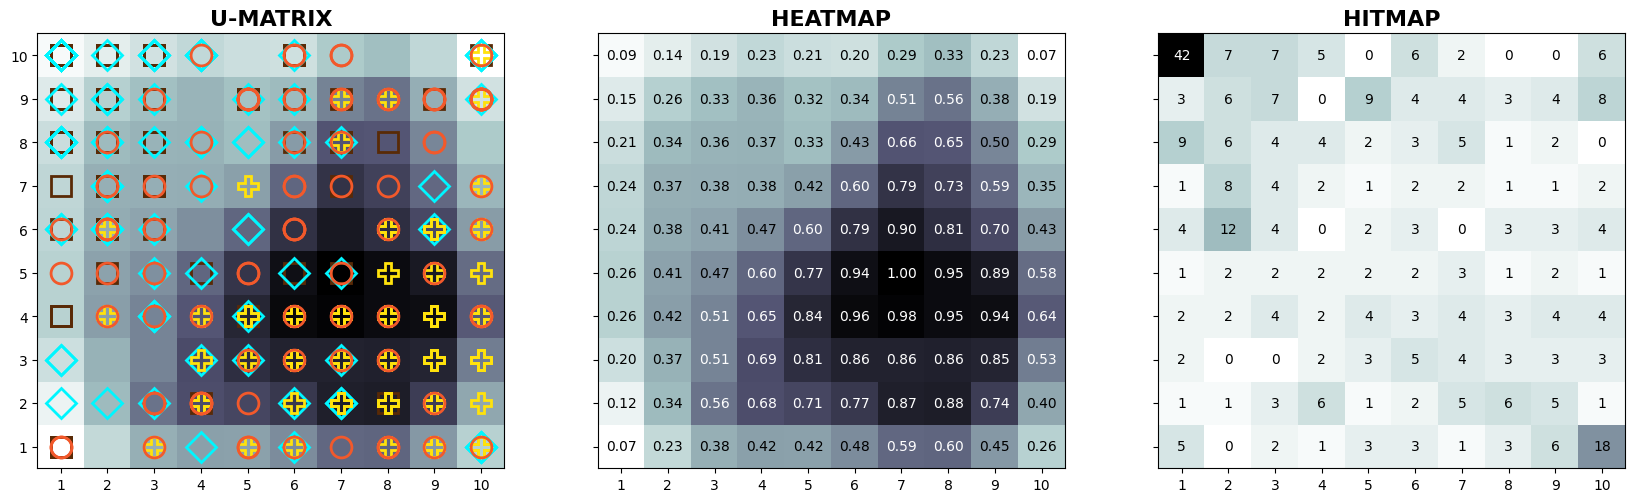

In [253]:
dpi = 100
width = np.round(1366 * 150 / 100)
height = 768*.75

fig, ax = plt.subplots(1, 3, figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor='w', sharex=True, sharey=True)
ax[0].pcolor(SOM.distance_map().T, cmap='bone_r')

markers = {0: 's', 1: 'D', 2: 'P', 3: 'o'}

# for i, d in enumerate(data):
#     x, y = SOM.winner(d)
#     ax[0].plot(x+0.5, y+0.5, markerfacecolor='None', markersize=15, 
#                markeredgewidth=2, marker=markers[color_map[x][y]], 
#                color=colors[color_map[x][y]])

for i, d in enumerate(data):
    x, y = SOM.winner(d)
    ax[0].plot(x+0.5, y+0.5, markerfacecolor='None', markersize=15, 
               markeredgewidth=2, marker=markers[flashes_df.iloc[i, 0]], 
               color=colors[flashes_df.iloc[i, 0]])
    
    
ax[0].set_title('U-MATRIX', fontdict={'size': 16, 'fontweight': 'bold'})
ax[0].set_xticks(np.arange(ncol)+0.5)
ax[0].set_yticks(np.arange(nrow)+0.5)
ax[0].set_xticklabels(np.arange(ncol)+1)
ax[0].set_yticklabels(np.arange(nrow)+1)


dm = SOM.distance_map().T
ax[1].pcolor(dm, cmap='bone_r')
for i in range(dm.shape[0]):
    for j in range(dm.shape[1]):
        color = 'w' if dm[i][j] > dm.max()/2 else 'k'
        ax[1].text(j+0.5, i+0.5, '%.2f'%dm[i][j], ha='center', va='center', color=color)
ax[1].set_title('HEATMAP', fontdict={'size': 16, 'fontweight': 'bold'})
ax[1].set_xticks(np.arange(ncol)+0.5)
ax[1].set_yticks(np.arange(nrow)+0.5)
ax[1].set_xticklabels(np.arange(ncol)+1)
ax[1].set_yticklabels(np.arange(nrow)+1)


freq = SOM.activation_response(data).astype(int)
ax[2].pcolor(freq.T, cmap='bone_r') 
for (i, j), z in np.ndenumerate(freq.T):
    color = 'w' if z > freq.T.max()/2 else 'k'
    ax[2].text(j+0.5, i+0.5, z, ha='center', va='center', color=color)
# ax[1].colorbar(cmap)
ax[2].set_title('HITMAP', fontdict={'size': 16, 'fontweight': 'bold'})
ax[2].set_xticks(np.arange(ncol)+0.5)
ax[2].set_yticks(np.arange(nrow)+0.5)
ax[2].set_xticklabels(np.arange(ncol)+1)
ax[2].set_yticklabels(np.arange(nrow)+1)

plt.savefig(f"../metrics_uf_hourly.png",                                            
                transparent=False, bbox_inches='tight', pad_inches=0.1)

array([1596, 172248, 2.54413328606877, 27.350487881006618, 0.0, 0.0, 0.0,
       0.0, 0.0, 1.0, 2.0, 10.0, 56.0], dtype=object)

0

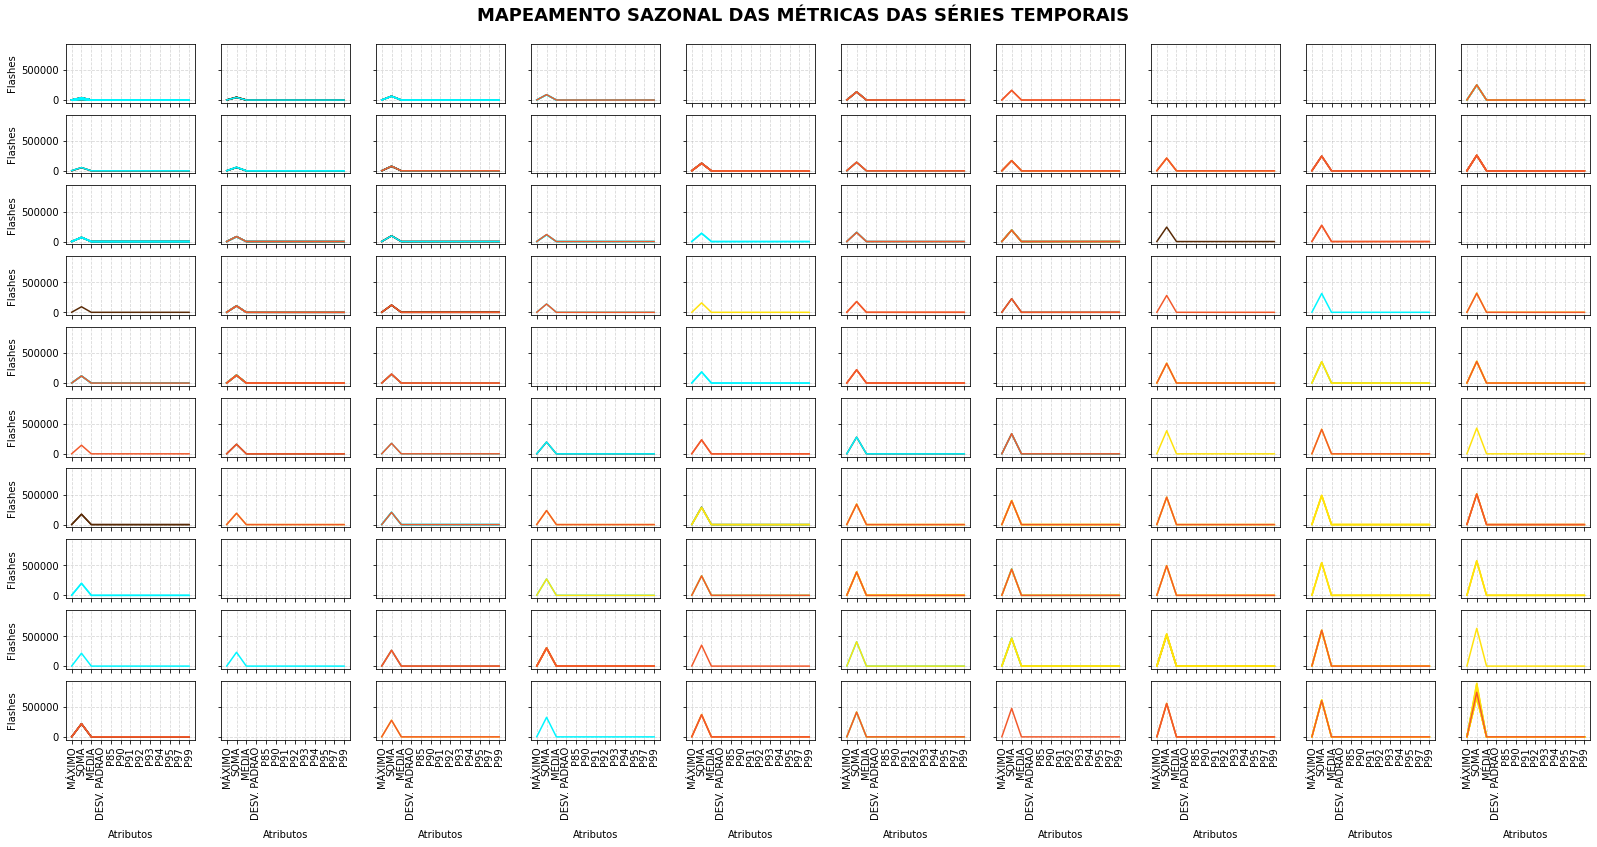

In [306]:
dpi = 150
width = np.round(1366 * 300 / 100)
height = 768*2.5

fig, ax = plt.subplots(nrow, ncol, figsize=(width/dpi, height/dpi), 
                                            sharex=True, sharey=True, facecolor='w')

fig.suptitle("MAPEAMENTO SAZONAL DAS MÉTRICAS DAS SÉRIES TEMPORAIS", 
             y=0.92, fontsize=18, fontweight='bold')

for i, (_, row) in  enumerate(flashes_df.iterrows()):
    x, y = SOM.winner(row[2:]['total'].values.astype(np.float32))
    ax[(ncol-1)-y][x].plot(row[2:]['total'].values, color=colors[row['stations'][0]])

for i in range(nrow*ncol):
    row = i//nrow
    col = i%ncol
    ax[row][col].grid(ls='--', alpha=0.5)
    if col == 0:
        ax[row][col].set_ylabel("Flashes")
    if row == nrow-1:
        ax[row][col].set_xlabel("Atributos", labelpad=10)
        ax[row][col].set_xticks(np.arange(len(columns)))
        ax[row][col].set_xticklabels(columns)
        ax[row][col].tick_params(axis='x', rotation=90)
                       
plt.savefig(f"../neurons_series_uf_mean10d_prob.png", dpi=dpi,                                      
                transparent=False, bbox_inches='tight', pad_inches=0.1)

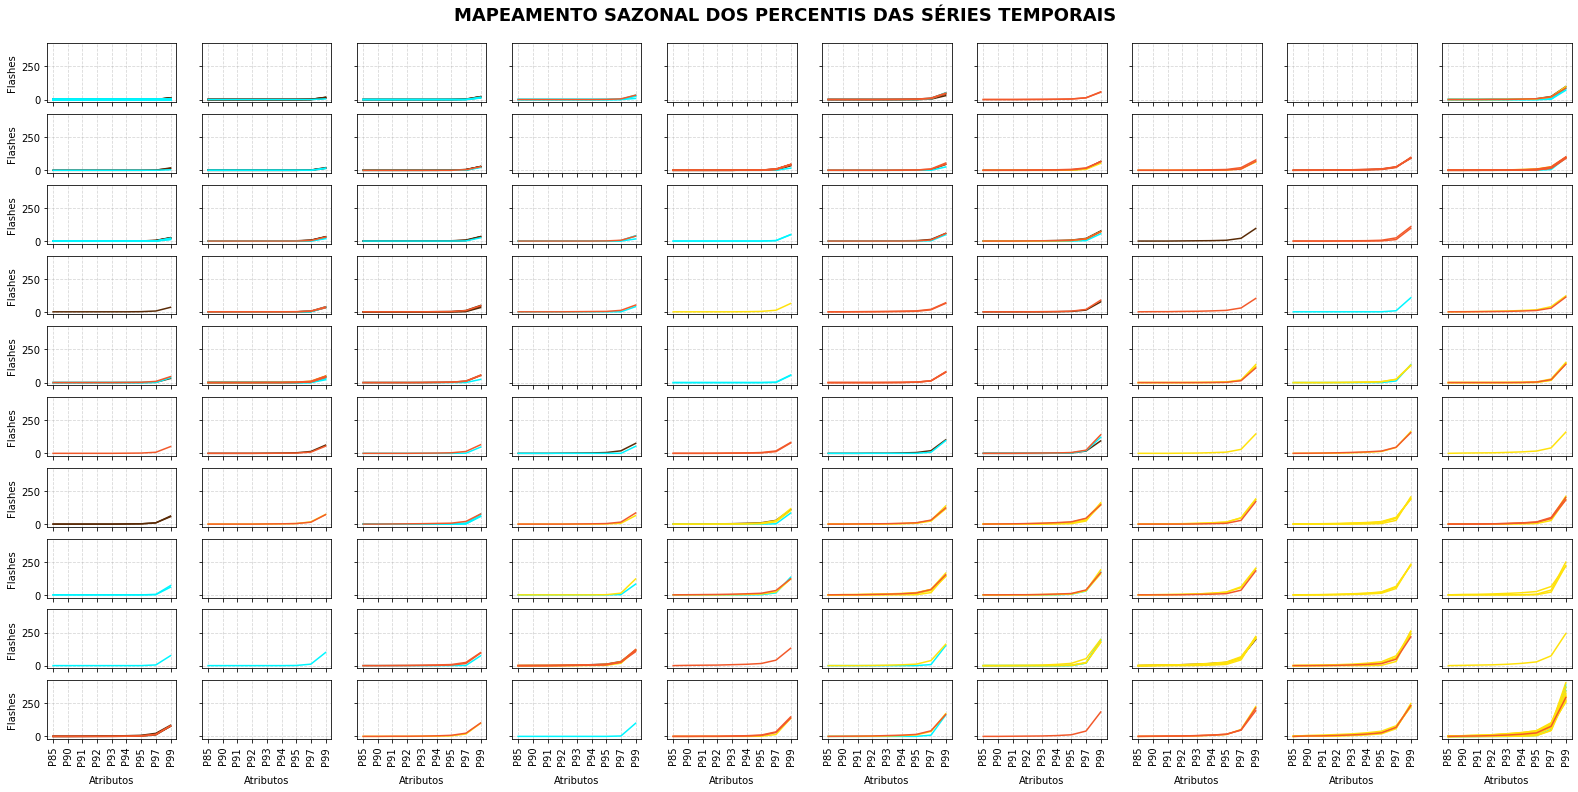

In [310]:
dpi = 150
width = np.round(1366 * 300 / 100)
height = 768*2.5

fig, ax = plt.subplots(nrow, ncol, figsize=(width/dpi, height/dpi), 
                                            sharex=True, sharey=True, facecolor='w')

fig.suptitle("MAPEAMENTO SAZONAL DOS PERCENTIS DAS SÉRIES TEMPORAIS", 
             y=0.92, fontsize=18, fontweight='bold')

for i, (_, row) in  enumerate(flashes_df.iterrows()):
    x, y = SOM.winner(row[2:]['total'].values.astype(np.float32))
    ax[(ncol-1)-y][x].plot(row[2:]['total'].values[4:], color=colors[row['stations'][0]])

for i in range(nrow*ncol):
    row = i//nrow
    col = i%ncol
    ax[row][col].grid(ls='--', alpha=0.5)
    if col == 0:
        ax[row][col].set_ylabel("Flashes")
    if row == nrow-1:
        ax[row][col].set_xlabel("Atributos", labelpad=10)
        ax[row][col].set_xticks(np.arange(len(columns))[:-4])
        ax[row][col].set_xticklabels(columns[4:])
        ax[row][col].tick_params(axis='x', rotation=90)
                       
plt.savefig(f"../neurons_series_uf_mean10d_pcts.png", dpi=dpi,                                      
                transparent=False, bbox_inches='tight', pad_inches=0.1)